# 1)

In [1]:
import numpy as np
from varname import nameof

# adapted from stack overflow
def bmatrix(a, var_name, exercise=1):
    """Stores in a file a LaTeX bmatrix from a numpy array."""
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join([f"{float(x):.6g}" for x in l.split()]) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    with open(f"./aux-matrices/ex-{exercise}/{var_name}.tex", 'w+') as f:
      f.write('\n'.join(rv))

In [2]:
mu_1 = np.array([2, 0]).reshape(-1, 1)
mu_2 = np.array([2, 1]).reshape(-1, 1)

bmatrix(mu_1, nameof(mu_1))
bmatrix(mu_2, nameof(mu_2))

In [3]:
SAMPLES = [x.reshape(-1, 1) for x in np.array([[0, 0], [1, 0], [0, 2], [2, 2]])]
[x_1, x_2, x_3, x_4] = SAMPLES

bmatrix(x_1, nameof(x_1))
bmatrix(x_2, nameof(x_2))
bmatrix(x_3, nameof(x_3))
bmatrix(x_4, nameof(x_4))

In [4]:
def update_mu(samples, mu_1, mu_2, mu_3=None):
  mu_1_distances = [np.linalg.norm(x - mu_1)**2 for x in samples]
  mu_2_distances = [np.linalg.norm(x - mu_2)**2 for x in samples]
  print(f"mu_1_distances: {['{:.4g}'.format(d) for d in mu_1_distances]}")
  print(f"mu_2_distances: {['{:.4g}'.format(d) for d in mu_2_distances]}")
  if mu_3 is not None:
    mu_3_distances = [np.linalg.norm(x - mu_3)**2 for x in samples]
    print(f"mu_3_distances: {['{:.4g}'.format(d) for d in mu_3_distances]}")
  mu_1_assignments, mu_2_assignments, mu_3_assignments = [], [], []
  for i in range(len(samples)):
    if mu_3 is not None:
      assignment = np.argmin([mu_1_distances[i], mu_2_distances[i], mu_3_distances[i]])
    else:
      assignment = np.argmin([mu_1_distances[i], mu_2_distances[i]])
    eval(f"mu_{assignment + 1}_assignments").append(samples[i])
  print(f"mu_1_assignments: {mu_1_assignments}")
  print(f"mu_2_assignments: {mu_2_assignments}")
  if mu_3 is not None:
    print(f"mu_3_assignments: {mu_3_assignments}")

  # Then, update the centroids
  new_mu_1 = np.mean([x for x in mu_1_assignments], axis=0)
  new_mu_2 = np.mean([x for x in mu_2_assignments], axis=0)
  print(f"new_mu_1: {new_mu_1}")
  print(f"new_mu_2: {new_mu_2}")
  if mu_3 is not None:
    new_mu_3 = np.mean([x for x in mu_3_assignments], axis=0)
    print(f"new_mu_3: {new_mu_3}")

  return (new_mu_1, new_mu_2) if mu_3 is None else (new_mu_1, new_mu_2, new_mu_3)

changed = True
i = 1
while changed:
  changed = not changed
  # set new variables new_mu_1_i and new_mu_2_i
  exec(f"new_mu_1_{i}, new_mu_2_{i} = update_mu(SAMPLES, mu_1, mu_2)")
  bmatrix(eval(f"new_mu_1_{i}"), f"new_mu_1_{i}")
  bmatrix(eval(f"new_mu_2_{i}"), f"new_mu_2_{i}")
  if not np.array_equal(eval(f"new_mu_1_{i}"), mu_1) or not np.array_equal(eval(f"new_mu_2_{i}"), mu_2):
    changed = True
  mu_1, mu_2 = eval(f"new_mu_1_{i}"), eval(f"new_mu_2_{i}")
  i += 1

mu_1_distances: ['4', '1', '8', '4']
mu_2_distances: ['5', '2', '5', '1']
mu_1_assignments: [array([[0],
       [0]]), array([[1],
       [0]])]
mu_2_assignments: [array([[0],
       [2]]), array([[2],
       [2]])]
new_mu_1: [[0.5]
 [0. ]]
new_mu_2: [[1.]
 [2.]]
mu_1_distances: ['0.25', '0.25', '4.25', '6.25']
mu_2_distances: ['5', '4', '1', '1']
mu_1_assignments: [array([[0],
       [0]]), array([[1],
       [0]])]
mu_2_assignments: [array([[0],
       [2]]), array([[2],
       [2]])]
new_mu_1: [[0.5]
 [0. ]]
new_mu_2: [[1.]
 [2.]]


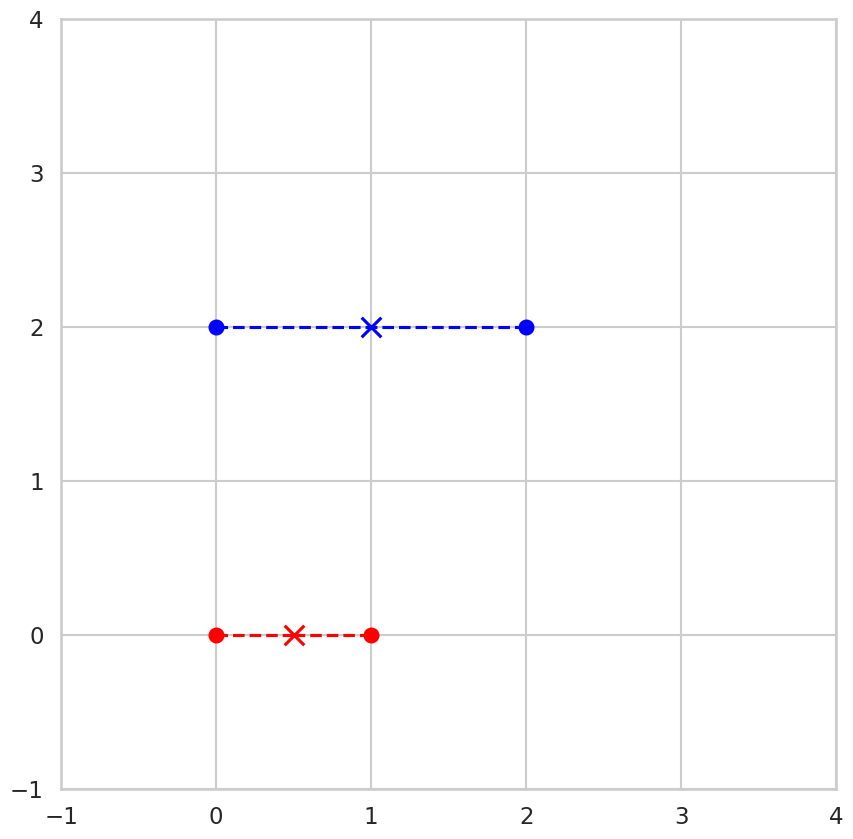

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(-1, 4)
ax.set_ylim(-1, 4)

# Plot centroids
ax.scatter(mu_1[0], mu_1[1], s=200, c='red', marker='x')
ax.scatter(mu_2[0], mu_2[1], s=200, c='blue', marker='x')

# Plot sample assignments
for x in SAMPLES:
  if np.linalg.norm(x - mu_1)**2 < np.linalg.norm(x - mu_2)**2:
    ax.scatter(x[0], x[1], s=100, c='red')
  else:
    ax.scatter(x[0], x[1], s=100, c='blue')

# Plot lines from each sample to its centroid
for x in SAMPLES:
  if np.linalg.norm(x - mu_1)**2 < np.linalg.norm(x - mu_2)**2:
    ax.plot([x[0], mu_1[0]], [x[1], mu_1[1]], linestyle='--', color='red')
  else:
    ax.plot([x[0], mu_2[0]], [x[1], mu_2[1]], linestyle='--', color='blue')

plt.savefig("./assets/k-means-clusters.png")

In [6]:
# calculate silhouete for each sample:

def silhouette(samples, mu_1, mu_2):
  mu_1_distances = [np.linalg.norm(x - mu_1)**2 for x in samples]
  mu_2_distances = [np.linalg.norm(x - mu_2)**2 for x in samples]
  mu_1_assignments, mu_2_assignments = [], []
  for i in range(len(samples)):
    if mu_1_distances[i] < mu_2_distances[i]:
      mu_1_assignments.append(samples[i])
    else:
      mu_2_assignments.append(samples[i])
  
  a, b = [], []
  for x in samples:
    if any(np.array_equal(x, y) for y in mu_1_assignments):
      a_num = np.sum([np.linalg.norm(x - x_i) for x_i in mu_1_assignments])
      a_den = len(mu_1_assignments) - 1
      b_num = np.sum([np.linalg.norm(x - x_i) for x_i in mu_2_assignments])
      b_den = len(mu_2_assignments)
    else:
      a_num = np.sum([np.linalg.norm(x - x_i) for x_i in mu_2_assignments])
      a_den = len(mu_2_assignments) - 1
      b_num = np.sum([np.linalg.norm(x - x_i) for x_i in mu_1_assignments])
      b_den = len(mu_1_assignments)
    a.append(a_num / a_den)
    b.append(b_num / b_den)

  print(f"a: {['{:.4g}'.format(d) for d in a]}")
  print(f"b: {['{:.4g}'.format(d) for d in b]}")
  s = []
  for i in range(len(samples)):
    s.append((b[i] - a[i]) / max(a[i], b[i]))

  return s

s = silhouette(SAMPLES, mu_1, mu_2)

print(f"silhouette: {['{:.4f}'.format(s_i) for s_i in s]}")

# calculate the average silhouette for the cluster assignments:

s_k_1 = np.mean([s[i] for i in range(len(SAMPLES)) if np.linalg.norm(SAMPLES[i] - mu_1)**2 < np.linalg.norm(SAMPLES[i] - mu_2)**2])
s_k_2 = np.mean([s[i] for i in range(len(SAMPLES)) if np.linalg.norm(SAMPLES[i] - mu_1)**2 > np.linalg.norm(SAMPLES[i] - mu_2)**2])

print(f"s_k_1: {s_k_1}")
print(f"s_k_2: {s_k_2}")

a: ['1', '1', '2', '2']
b: ['2.414', '2.236', '2.118', '2.532']
silhouette: ['0.5858', '0.5528', '0.0557', '0.2102']
s_k_1: 0.5692864210634736
s_k_2: 0.13295794683615367


# 2)

In [7]:
SAMPLES = [x.reshape(-1, 1) for x in np.array([[1, 0, 0], [8, 8, 4], [3, 3, 0], [0, 0, 1], [0, 1, 0], [3, 2, 1]])]
[x_1, x_2, x_3, x_4, x_5, x_6] = SAMPLES

bmatrix(x_1, nameof(x_1))
bmatrix(x_2, nameof(x_2))
bmatrix(x_3, nameof(x_3))
bmatrix(x_4, nameof(x_4))
bmatrix(x_5, nameof(x_5))
bmatrix(x_6, nameof(x_6))

for k = 2:

In [8]:
mu_1_2, mu_2_2 = x_1, x_2

changed = True
while changed:
  changed = not changed
  new_mu_1_2, new_mu_2_2 = update_mu(SAMPLES, mu_1_2, mu_2_2)
  if not np.array_equal(new_mu_1_2, mu_1_2) or not np.array_equal(new_mu_2_2, mu_2_2):
    changed = True
    mu_1_2, mu_2_2 = new_mu_1_2, new_mu_2_2

print(f"mu_1_2: {mu_1_2}")
print(f"mu_2_2: {mu_2_2}")

bmatrix(mu_1_2, nameof(mu_1_2), exercise=2)
bmatrix(mu_2_2, nameof(mu_2_2), exercise=2)

mu_1_distances: ['0', '129', '13', '2', '2', '9']
mu_2_distances: ['129', '0', '66', '137', '129', '70']
mu_1_assignments: [array([[1],
       [0],
       [0]]), array([[3],
       [3],
       [0]]), array([[0],
       [0],
       [1]]), array([[0],
       [1],
       [0]]), array([[3],
       [2],
       [1]])]
mu_2_assignments: [array([[8],
       [8],
       [4]])]
new_mu_1: [[1.4]
 [1.2]
 [0.4]]
new_mu_2: [[8.]
 [8.]
 [4.]]
mu_1_distances: ['1.76', '102.8', '5.96', '3.76', '2.16', '3.56']
mu_2_distances: ['129', '0', '66', '137', '129', '70']
mu_1_assignments: [array([[1],
       [0],
       [0]]), array([[3],
       [3],
       [0]]), array([[0],
       [0],
       [1]]), array([[0],
       [1],
       [0]]), array([[3],
       [2],
       [1]])]
mu_2_assignments: [array([[8],
       [8],
       [4]])]
new_mu_1: [[1.4]
 [1.2]
 [0.4]]
new_mu_2: [[8.]
 [8.]
 [4.]]
mu_1_2: [[1.4]
 [1.2]
 [0.4]]
mu_2_2: [[8.]
 [8.]
 [4.]]


for k = 3

In [9]:
mu_1_3, mu_2_3, mu_3_3 = x_1, x_2, x_3

changed = True
while changed:
  changed = not changed
  new_mu_1_3, new_mu_2_3, new_mu_3_3 = update_mu(SAMPLES, mu_1_3, mu_2_3, mu_3_3)
  if not np.array_equal(new_mu_1_3, mu_1_3) or not np.array_equal(new_mu_2_3, mu_2_3) or not np.array_equal(new_mu_3_3, mu_3_3):
    changed = True
    mu_1_3, mu_2_3, mu_3_3 = new_mu_1_3, new_mu_2_3, new_mu_3_3

print(f"mu_1_3: {mu_1_3}")
print(f"mu_2_3: {mu_2_3}")
print(f"mu_3_3: {mu_3_3}")

bmatrix(mu_1_3, nameof(mu_1_3), exercise=2)
bmatrix(mu_2_3, nameof(mu_2_3), exercise=2)
bmatrix(mu_3_3, nameof(mu_3_3), exercise=2)

mu_1_distances: ['0', '129', '13', '2', '2', '9']
mu_2_distances: ['129', '0', '66', '137', '129', '70']
mu_3_distances: ['13', '66', '0', '19', '13', '2']
mu_1_assignments: [array([[1],
       [0],
       [0]]), array([[0],
       [0],
       [1]]), array([[0],
       [1],
       [0]])]
mu_2_assignments: [array([[8],
       [8],
       [4]])]
mu_3_assignments: [array([[3],
       [3],
       [0]]), array([[3],
       [2],
       [1]])]
new_mu_1: [[0.33333333]
 [0.33333333]
 [0.33333333]]
new_mu_2: [[8.]
 [8.]
 [4.]]
new_mu_3: [[3. ]
 [2.5]
 [0.5]]
mu_1_distances: ['0.6667', '131', '14.33', '0.6667', '0.6667', '10.33']
mu_2_distances: ['129', '0', '66', '137', '129', '70']
mu_3_distances: ['10.5', '67.5', '0.5', '15.5', '11.5', '0.5']
mu_1_assignments: [array([[1],
       [0],
       [0]]), array([[0],
       [0],
       [1]]), array([[0],
       [1],
       [0]])]
mu_2_assignments: [array([[8],
       [8],
       [4]])]
mu_3_assignments: [array([[3],
       [3],
       [0]]), array([[

In [10]:
# calculate cohesion for both cluster assignments:

def cohesion(samples, mu_1, mu_2, mu_3=None):
  mu_1_distances = [np.linalg.norm(x - mu_1) for x in samples]
  mu_2_distances = [np.linalg.norm(x - mu_2) for x in samples]
  if mu_3 is not None:
    mu_3_distances = [np.linalg.norm(x - mu_3) for x in samples]
  mu_1_assignments, mu_2_assignments, mu_3_assignments = [], [], []
  for i in range(len(samples)):
    if mu_3 is None:
      assignment = np.argmin([mu_1_distances[i], mu_2_distances[i]])
    else:
      assignment = np.argmin([mu_1_distances[i], mu_2_distances[i], mu_3_distances[i]])
    eval(f"mu_{assignment + 1}_assignments").append(samples[i])

  if mu_3 is None:
    return np.sum([np.linalg.norm(x - mu_1)**2 for x in mu_1_assignments]) + np.sum([np.linalg.norm(x - mu_2)**2 for x in mu_2_assignments])
  return np.sum([np.linalg.norm(x - mu_1)**2 for x in mu_1_assignments]) + np.sum([np.linalg.norm(x - mu_2)**2 for x in mu_2_assignments]) + np.sum([np.linalg.norm(x - mu_3)**2 for x in mu_3_assignments])

c_k_2 = cohesion(SAMPLES, mu_1_2, mu_2_2)
print(f"c_k_2: {c_k_2}")

c_k_3 = cohesion(SAMPLES, mu_1_3, mu_2_3, mu_3_3)
print(f"c_k_3: {c_k_3}")

c_k_2: 17.200000000000003
c_k_3: 3.0


In [11]:
# calculate separation for both cluster assignments:

def separation(mu_arr):
  return np.sum([np.linalg.norm(mu - mu2)**2 for mu in mu_arr for mu2 in mu_arr]) / len(mu_arr)**2

s_k_2 = separation([mu_1_2, mu_2_2])
print(f"s_k_2: {s_k_2}")

s_k_3 = separation([mu_1_3, mu_2_3, mu_3_3])
print(f"s_k_3: {s_k_3}")

s_k_2: 51.379999999999995
s_k_3: 46.74074074074074


# 3)

In [12]:
from statistics import NormalDist

SAMPLES = [4, 0, 1]
PRIORS = [0.5, 0.5]
[p_k1, p_k2] = PRIORS
mu_k_1, mu_k_2 = 1, 0
sigma_k_1, sigma_k_2 = 1, 1

def calc_likelihood(mu, sigma, x):
  return NormalDist(mu, sigma).pdf(x)

K_1_LIKELIHOODS = [calc_likelihood(mu_k_1, sigma_k_1, x) for x in SAMPLES]
K_2_LIKELIHOODS = [calc_likelihood(mu_k_2, sigma_k_2, x) for x in SAMPLES]
[l_1_k_1, l_2_k_1, l_3_k_1] = K_1_LIKELIHOODS
[l_1_k_2, l_2_k_2, l_3_k_2] = K_2_LIKELIHOODS

print(f"l_1_k_1: {l_1_k_1:.4g}")
print(f"l_2_k_1: {l_2_k_1:.4g}")
print(f"l_3_k_1: {l_3_k_1:.4g}")
print(f"l_1_k_2: {l_1_k_2:.4g}")
print(f"l_2_k_2: {l_2_k_2:.4g}")
print(f"l_3_k_2: {l_3_k_2:.4g}")

def calc_posterior(likelihoods, priors, l, p):
  return l * p / np.sum([l * p for l, p in zip(likelihoods, priors)])

likelihoods = []
for i in range(len(SAMPLES)):
  likelihoods.append([K_1_LIKELIHOODS[i], K_2_LIKELIHOODS[i]])

x_1_posteriors = [calc_posterior(likelihoods[0], PRIORS, l, p) for l, p in zip(likelihoods[0], PRIORS)]
x_2_posteriors = [calc_posterior(likelihoods[1], PRIORS, l, p) for l, p in zip(likelihoods[1], PRIORS)]
x_3_posteriors = [calc_posterior(likelihoods[2], PRIORS, l, p) for l, p in zip(likelihoods[2], PRIORS)]

[post_1_x_1, post_2_x_1] = x_1_posteriors
[post_1_x_2, post_2_x_2] = x_2_posteriors
[post_1_x_3, post_2_x_3] = x_3_posteriors

print("---")

print(f"post_1_x_1: {post_1_x_1:.4g}")
print(f"post_2_x_1: {post_2_x_1:.4g}")
print(f"post_1_x_2: {post_1_x_2:.4g}")
print(f"post_2_x_2: {post_2_x_2:.4g}")
print(f"post_1_x_3: {post_1_x_3:.4g}")
print(f"post_2_x_3: {post_2_x_3:.4g}")

l_1_k_1: 0.004432
l_2_k_1: 0.242
l_3_k_1: 0.3989
l_1_k_2: 0.0001338
l_2_k_2: 0.3989
l_3_k_2: 0.242
---
post_1_x_1: 0.9707
post_2_x_1: 0.02931
post_1_x_2: 0.3775
post_2_x_2: 0.6225
post_1_x_3: 0.6225
post_2_x_3: 0.3775


In [15]:
def update_means(posteriors, samples):
  return np.sum([p * s for p, s in zip(posteriors, samples)]) / np.sum(posteriors)

def update_sigma(posteriors, samples, means):
  return np.sqrt(np.sum([p * (s - m)**2 for p, s, m in zip(posteriors, samples, means)]) / np.sum(posteriors))

def update_priors(posteriors):
  return np.sum(posteriors) / len(posteriors)

new_mu_k_1 = update_means([post_1_x_1, post_1_x_2, post_1_x_3], SAMPLES)
new_mu_k_2 = update_means([post_2_x_1, post_2_x_2, post_2_x_3], SAMPLES)

new_sigma_k_1 = update_sigma([post_1_x_1, post_1_x_2, post_1_x_3], SAMPLES, [new_mu_k_1, new_mu_k_1, new_mu_k_1])
new_sigma_k_2 = update_sigma([post_2_x_1, post_2_x_2, post_2_x_3], SAMPLES, [new_mu_k_2, new_mu_k_2, new_mu_k_2])

new_p_k_1 = update_priors([post_1_x_1, post_1_x_2, post_1_x_3])
new_p_k_2 = update_priors([post_2_x_1, post_2_x_2, post_2_x_3])

print("---")

print(f"new_mu_k_1: {new_mu_k_1:.4g}")
print(f"new_mu_k_2: {new_mu_k_2:.4g}")
print(f"new_sigma_k_1: {new_sigma_k_1:.4g}")
print(f"new_sigma_k_2: {new_sigma_k_2:.4g}")
print(f"new_p_k_1: {new_p_k_1:.4g}")
print(f"new_p_k_2: {new_p_k_2:.4g}")

---
new_mu_k_1: 2.286
new_mu_k_2: 0.4807
new_sigma_k_1: 1.724
new_sigma_k_2: 0.769
new_p_k_1: 0.6569
new_p_k_2: 0.3431


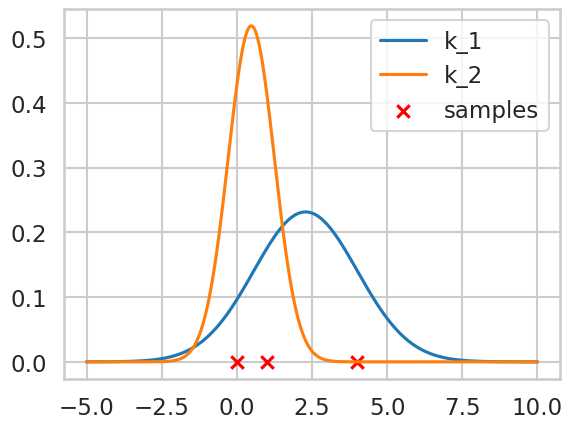

In [32]:
# plot both k1 and k2 distributions + samples

from scipy.stats import norm

x = np.linspace(-5, 10, 1000)
y_k_1 = norm.pdf(x, new_mu_k_1, new_sigma_k_1)
y_k_2 = norm.pdf(x, new_mu_k_2, new_sigma_k_2)

plt.plot(x, y_k_1, label="k_1")
plt.plot(x, y_k_2, label="k_2")
plt.scatter(SAMPLES, [0, 0, 0], label="samples", color="red", marker="x")
plt.legend()
plt.savefig("assets/ex-3-plot.png")